# Twitter Airline Sentiment Analysis and Model Evaluation

## 1. Creating a background environment

In [1]:
#Load all data
import pandas as pd
tweets_data = pd.read_csv('/Users/Mughundhan/UIC/UIC Academics/SPRING 2018/TEXT ANALYTICS/Assignment2/Tweets.csv',encoding="utf8")

## 2. Data Overview

In [2]:
tweets_data.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


#### Plot Sentiment Distribution for each Airline

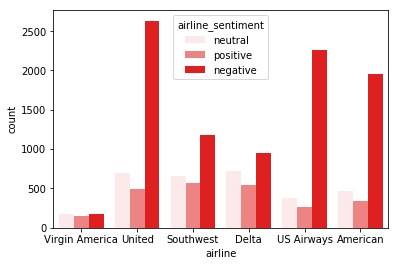

In [3]:
#Plot Sentiment Distribution
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
tweets_data_sub = tweets_data[['airline','airline_sentiment','text']]
sb.countplot(x="airline",hue="airline_sentiment", data=tweets_data_sub, color="Red")

## 2. Data Cleaning

#### Vectorize tweets using count vectorization
1. Remove URLs
2. Remove Mentions
3. Rename Hashtags
4. Modify Columns

In [4]:
import re

##Renaming Hashtag using Regular Expressions
regexp_Htag = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)'
pattern_Htag = re.compile(regexp_Htag, re.UNICODE | re.IGNORECASE)

##Remove Mention using Regular Expressions
regexp_mention = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z0-9_]+[A-Za-z0-9_]+)'
pattern_mention = re.compile(regexp_mention, re.UNICODE | re.IGNORECASE)

##Remove URLs using Regular Expressions
regexp_URL = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
pattern_URL = re.compile(regexp_URL, re.UNICODE | re.IGNORECASE)


data_final= []

for temp in tweets_data_sub['text']:   
    temp = re.sub(pattern_URL,'',temp) #Remove URLs
    temp = re.sub(pattern_mention,'',temp) #Remove Mentions
    temp = re.sub('#','hashtag_', temp) #Rename Hashtag
    data_final.append(temp)

data_final= pd.DataFrame(data_final)
print(data_final.shape)
tweets_data_final = tweets_data_sub.join(data_final)

del tweets_data_final['text'] #Remove unwanted column

tweets_data_final.columns = ['airline', 'airline_sentiment','text'] #Rename column names

#Count vectorization:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

vectorizer = CountVectorizer()
vectorizer.fit(tweets_data_final['text'])
vector = vectorizer.transform(tweets_data_final['text'])
print(vector.shape)

(14640, 1)
(14640, 13639)


## 3. Train using Logistic Regression Classifier and K-Fold Classification

In [83]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics  import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

unique_airline= tweets_data_final['airline'].unique()

print("Trained using Logistic Regression")
print("-------------------")

def acc_score(airline):
    airline_data = tweets_data_final[tweets_data_final['airline']==airline]
    airline_data = airline_data.reset_index(drop=True)
    accuracy = []
    f_score = []
    
    kf10 = KFold(n_splits=10) #10 fold cross-validation
    for train, valid in kf10.split(airline_data['airline_sentiment']):
        X_train_text = airline_data['text'][train]
        y_train = airline_data['airline_sentiment'][train]
        X_valid_text = airline_data['text'][valid]
        y_valid = airline_data['airline_sentiment'][valid]
        
        #Using Count Vectorizer
        vect = CountVectorizer(min_df = 1, stop_words = 'english')
        X_train = vect.fit_transform(X_train_text)
        X_valid = vect.transform(X_valid_text)
        
        #Using Logistic Regression
        lr = LogisticRegression(C = 5)
        lr.fit(X_train, y_train)

        p_valid = lr.predict(X_valid)
        accuracy.append(accuracy_score(y_valid, p_valid))
        f_score.append(f1_score(y_valid, p_valid, average='weighted'))
    
    accuracy = np.array(accuracy).mean(0)
    f_score = np.array(f_score).mean(0)
    
    #Printing the Airlines Name, Accuracy and F1 Score
    print(airline)
    print("Accuracy:  %.04f" % accuracy)
    print("F1 Score:  %.04f" % f_score)
    print("-------------------")
    
for i in range (6):
    acc_score(unique_airline[i])

Trained using Logistic Regression
-------------------
US Airways
Accuracy:  0.8122
F1 Score:  0.7955
-------------------
Southwest
Accuracy:  0.7128
F1 Score:  0.7133
-------------------
American
Accuracy:  0.7992
F1 Score:  0.7885
-------------------
United
Accuracy:  0.7470
F1 Score:  0.7357
-------------------
Delta
Accuracy:  0.6796
F1 Score:  0.6794
-------------------
Virgin America
Accuracy:  0.6426
F1 Score:  0.6437
-------------------


#### Analysis

    A. F1 Score is the weighted average of Precision and Recall, hence this takes both False Positives and False Negatives into account.
    B. Since we have an uneven class distribution, F1 score is more useful than Accuracy in this case. Given that we perform Logistic Regression which is a discriminative model, performs better as the training data size reaches infinity.
    C. Based on both the parameters we can say that US Airways performs better than other airlines which is followed by American Airlines.
    D. On the other hand, Virgin America airlines' performance seems to the poorest based on these metrics which is followed by Delta Airlines.

## 4. Train using Multinomial Naïve Bayes Classifier and K-Fold Classification

In [84]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

unique_airline= tweets_data_final['airline'].unique()

print("Trained using Multinomial Naive Bayes")
print("-------------------")

def acc_score(airline):
    airline_data = tweets_data_final[tweets_data_final['airline']==airline]
    airline_data = airline_data.reset_index(drop=True)
    accuracy = []
    f_score = []
    
    kf10 = KFold(n_splits=10) #10 fold cross-validation
    for train, valid in kf10.split(airline_data['airline_sentiment']):
        X_train_text = airline_data['text'][train]
        y_train = airline_data['airline_sentiment'][train]
        X_valid_text = airline_data['text'][valid]
        y_valid = airline_data['airline_sentiment'][valid]
        
        #Using Count Vectorizer
        vect = CountVectorizer(min_df = 1, stop_words = 'english')
        X_train = vect.fit_transform(X_train_text)
        X_valid = vect.transform(X_valid_text)
        
        #Using Multinomial Naive Bayes
        mnb = MultinomialNB(1e-10)
        mnb.fit(X_train, y_train)

        p_valid = mnb.predict(X_valid)
        accuracy.append(accuracy_score(y_valid, p_valid))
        f_score.append(f1_score(y_valid, p_valid, average='weighted'))
    
    accuracy = np.array(accuracy).mean(0)
    f_score = np.array(f_score).mean(0)
    
    #Printing the Airlines Name, Accuracy and F1 Score
    print(airline)
    print("Accuracy:  %.04f" % accuracy)
    print("F1 Score:  %.04f" % f_score)
    print("-------------------")
    
for i in range (6):
    acc_score(unique_airline[i])

Trained using Multinomial Naive Bayes
-------------------
US Airways
Accuracy:  0.8012
F1 Score:  0.7711
-------------------
Southwest
Accuracy:  0.6773
F1 Score:  0.6664
-------------------
American
Accuracy:  0.7767
F1 Score:  0.7517
-------------------
United
Accuracy:  0.7321
F1 Score:  0.7054
-------------------
Delta
Accuracy:  0.6490
F1 Score:  0.6413
-------------------
Virgin America
Accuracy:  0.5913
F1 Score:  0.5867
-------------------


#### Analysis:
    A. We can see a marginal dip in F1 score as well as Accuracy for the airlines corresponding to Multinomial Naive Bayes when compared with Logistic Regression.
    B. Since Naive Bayes is a Generative Model, it performs not as good as Logistic Regression as the training size increases.
    B. Based on both the parameters we can say that US Airways performs better than other airlines which is followed by American Airlines (similar to the case in Logistic Regression).
    C. On the other hand, Virgin America airlines' performance seems to the poorest based on these metrics which is followed by Delta Airlines (similar to the case in Logistic Regression).

## 5. Merge all airlines together
#### a. Train using Logistic Regression Classifier
#### b. Train using Multinomial Naïve Bayes Classifier
#### c. Perform K-Fold Classification.

In [85]:
#Initializations
accuracy_lr = []
f_score_lr = []
accuracy_mnb = []
f_score_mnb = []

kf10 = KFold(n_splits=10) #10 fold cross-validation

for train, valid in kf10.split(tweets_data_final['airline_sentiment']):
    X_train_text = tweets_data_final['text'][train]
    y_train = tweets_data_final['airline_sentiment'][train]

    X_valid_text = tweets_data_final['text'][valid]
    y_valid = tweets_data_final['airline_sentiment'][valid]

    vect = CountVectorizer(min_df = 1, stop_words = 'english')

    X_train = vect.fit_transform(X_train_text)
    X_valid = vect.transform(X_valid_text)

    # Computations for Logistic Regression
    LR_All = LogisticRegression(C = 5)
    LR_All.fit(X_train, y_train)

    p_valid = LR_All.predict(X_valid)
    accuracy_lr.append(accuracy_score(y_valid, p_valid))
    f_score_lr.append(f1_score(y_valid, p_valid, average='weighted'))
        
    # Computations for Multinomial Naive Bayes
    MNB_All = MultinomialNB(1e-10)
    MNB_All.fit(X_train, y_train)
    
    p_valid_MNB = MNB_All.predict(X_valid)
    accuracy_mnb.append(accuracy_score(y_valid, p_valid_MNB))
    f_score_mnb.append(f1_score(y_valid, p_valid_MNB, average='weighted'))    

#Logistic Regression
accuracy_lr = np.array(accuracy_lr).mean(0)
f_score_lr = np.array(f_score_lr).mean(0)
print("Computations for Logistic Regression")
print("Accuracy:  %.04f" % accuracy_lr)
print("F1 Score:  %.04f" % f_score_lr)

print("---------------------------------------------------------")
print("---------------------------------------------------------")

#Multinomial Naive Bayes
accuracy_mnb = np.array(accuracy_mnb).mean(0)
f_score_mnb = np.array(f_score_mnb).mean(0)
print("Computations for Multinomial Naive Bayes")
print("Accuracy:  %.04f" % accuracy_mnb)
print("F1 Score:  %.04f" % f_score_mnb)

Computations for Logistic Regression
Accuracy:  0.7693
F1 Score:  0.7654
---------------------------------------------------------
---------------------------------------------------------
Computations for Multinomial Naive Bayes
Accuracy:  0.7190
F1 Score:  0.7025


#### Analysis:

    A. We can see that Logistic Regression outperforms Multinomial Naive Bayes in this case.
    B. In general, Naive Bayes Algorithms work well with dataset of smaller sizes because the prior probabilities shall be used to predict results.
    C. As the size of the training data increases, Logistic Regression outperforms Naive Bayes.

## 6. Plot a Learning Curve by gradually adding training data points

In [75]:
#Random sampling and 80/20 Data Split
tweets_data_final = tweets_data_final.sample(frac=1, random_state= 100)

X_train_text1 = tweets_data_final['text'][:11713]
y_train1 = tweets_data_final['airline_sentiment'][:11713]

X_valid_text = tweets_data_final['text'][11713:]
y_valid = tweets_data_final['airline_sentiment'][11713:]

print(y_train1.shape, y_valid.shape)

((11713,), (2927,))


In [76]:
#Initializations
acc_score_lr = []
acc_score_mnb = []
metrics = [accuracy_score,f1_score]

#Generating a Learning Curve:
for i in range(586, 11713, 586): #Using the values we obtained using shape function
    
    X_train_text = X_train_text1[:i]
    y_train = y_train1[:i]
    
    #Performing Count Vectorizing on train and validation data
    vect = CountVectorizer(min_df = 1, stop_words = 'english')

    X_train = vect.fit_transform(X_train_text)
    X_valid = vect.transform(X_valid_text)

    #For Logistic Regression
    LR_Learning = LogisticRegression(C = 5)
    LR_Learning.fit(X_train, y_train)

    p_valid = LR_Learning.predict(X_valid)
    Accuracy_LR_Learning = accuracy_score(y_valid, p_valid)
    F_values_LR_Learning = f1_score(y_valid, p_valid, average='weighted')
    acc_score_lr.append([Accuracy_LR_Learning,F_values_LR_Learning])  
    
    #For Multinomial Naive Bayes
    MNB_Learning = MultinomialNB(1e-10)
    MNB_Learning.fit(X_train, y_train)
    
    p_valid_MNB = MNB_Learning.predict(X_valid)
    Accuracy_MNB_Learning = accuracy_score(y_valid, p_valid_MNB)
    F_values_MNB_Learning = f1_score(y_valid, p_valid_MNB, average='weighted')
    acc_score_mnb.append([Accuracy_MNB_Learning,F_values_MNB_Learning])
    
acc_score_lr = np.array(acc_score_lr)
acc_score_mnb = np.array(acc_score_mnb)

print('Logistic Regression Score:')
print(acc_score_lr)
print('Naive Bayes Score:')
print(acc_score_mnb)

Logistic Regression Score:
[[0.7273659  0.70921786]
 [0.73761531 0.72577561]
 [0.74069013 0.73409916]
 [0.75572258 0.7505313 ]
 [0.76050564 0.75634626]
 [0.76426375 0.7609529 ]
 [0.77041339 0.76718284]
 [0.77143833 0.76812154]
 [0.77348821 0.7711235 ]
 [0.77246327 0.77027762]
 [0.77280492 0.77124525]
 [0.77827127 0.77700729]
 [0.77895456 0.7775877 ]
 [0.77587974 0.77382998]
 [0.77895456 0.77778628]
 [0.78032115 0.77881336]
 [0.78066279 0.77936648]
 [0.77827127 0.77647873]
 [0.77758797 0.77614831]]
Naive Bayes Score:
[[0.68807653 0.64870264]
 [0.71814144 0.68587699]
 [0.71472497 0.68860502]
 [0.72258285 0.70163802]
 [0.7324906  0.71534686]
 [0.73488213 0.7188994 ]
 [0.72634096 0.70923831]
 [0.73522378 0.71909982]
 [0.73932354 0.72478095]
 [0.74000683 0.72632672]
 [0.7434233  0.73003086]
 [0.7434233  0.73100458]
 [0.74274001 0.73036431]
 [0.74683977 0.73380549]
 [0.74718141 0.73492524]
 [0.74820635 0.73622714]
 [0.75093953 0.73897339]
 [0.75230612 0.73999542]
 [0.74752306 0.73488263]]


#### Plot accuracy of Logistic Regression Classifier and Multinomial Naïve Bayes Classifier

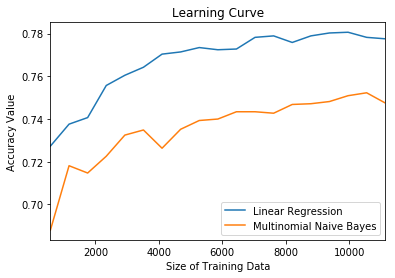

In [88]:
%matplotlib inline

size = np.arange(586, 11712, 586)
plt.title("Learning Curve")

plt.plot(size, acc_score_lr[:, 0], label = 'Linear Regression')
plt.plot(size, acc_score_mnb[:, 0], label = 'Multinomial Naive Bayes')

plt.xlabel('Size of Training Data')
plt.ylabel('Accuracy Value')
plt.xlim(size.min(), size.max())
plt.legend(loc = 'lower right')
plt.show()

#### Analysis:

    A. We can infer from the learning curve that the Logistic Regression outperforms Multinomial Naive Bayes.
    B. On adding additional training data, the accuracy of both the classifiers proves to increase with dips at certain points.
    C. But we can see that the Learning Curve for Logistic Regression is more steady as we increase the size of the training data. This is because it is a discriminative model which estimates the probability (y/x) directly from the training data by minimizing error.